### Phase fraction uncertainty quantification

For a given phase, define the normalized intensities as

$$Z_i = I_i / R_i$$

For now, we'll assume the $R_i$ are known completely while we figure out how to implement them efficiently in GSAS. (Either way this is likely a small component of uncertainty relative to the experimental variability of the $I_i$'s.)

There is uncertainty in the $I_i$'s both due to experimental set up as well as the fitting procedure. We'll assume these sources of uncertainty are independent, and thus additive. Thus we model

$$
I_i \sim N(\mu_I, \sigma_{I,exp}^2 + \sigma_{fit_i}^2)
$$

and so 

$$
Z_i \sim N\big(\mu_z, \sigma_{Z,exp}^2 + \frac{\sigma_{fit_i}^2}{R_i^{2}} \big)
$$

$\sigma^2_{fit_i}$ will be assumed known from the fitting procedure, while $\sigma^2_{Z,exp}$ will have to be estimated from data. Since we won't estimate $\mu_I$ and $\sigma^2_{I,exp}$ directly, we will simply denote $\mu_Z$ and $\sigma_Z$ as $\mu$ and $\sigma$ respectively.

In the Bayesian framework, we can write

\begin{align}
p(\mu, \sigma^2_{exp} | Z_i) &\propto p(Z_i|\mu, \sigma^2_{exp}) p(\mu, \sigma^2_{exp}) \\
&= N(Z_i,\mu,\sigma^2_{exp} + R_i^{-2}\sigma^2_{fit}) p(\mu,\sigma^2_{exp})
\end{align}

where the prior distributions will be a standard choice such as a truncated $t_4$ scaled to the MAD. 

Estimation for the other phases will follow similarly.

### Example

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import pymc3 as pm
from scipy.stats import median_abs_deviation as mad
import plotly.express as px
import seaborn as sns
from scipy.stats import invgamma, t
from statsmodels.stats.meta_analysis import combine_effects


In [50]:
print(az.__version__)
print(pm.__version__)

0.11.2
3.6


In [70]:
indata = pd.read_csv('intensity_table.csv')

In [71]:
#indata.head()

In [72]:
mydf = pd.DataFrame({
    'I':indata.int_fit,
    'R':indata.R_calc,
    'sigma_I':indata.u_int_fit,
    'phases':indata.Phase,
    'two_th':indata.two_theta
})

mydf['IR'] = mydf.I / mydf.R
mydf['sig_IR'] = mydf['sigma_I']/mydf.R

mydf = mydf.sort_values('phases').reset_index(drop=True)

In [73]:
print(mydf)

            I           R  sigma_I                phases   two_th        IR  \
0   21716.194  261157.488  168.301  austenite-SRM487.cif   43.593  0.083154   
1    7812.145  122379.402  123.253  austenite-SRM487.cif   50.777  0.063835   
2    4734.357   70554.804  103.257  austenite-SRM487.cif   74.651  0.067102   
3    4864.974   80763.209  110.421  austenite-SRM487.cif   90.633  0.060238   
4    1368.346   23555.357   80.239  austenite-SRM487.cif   95.910  0.058091   
5      92.318   13186.997   47.393  austenite-SRM487.cif  118.074  0.007001   
6   62590.189  188543.096  258.280    ferrite-SRM487.cif   44.575  0.331968   
7    7283.611   29667.204  113.272    ferrite-SRM487.cif   64.871  0.245511   
8   17954.038   58818.348  152.070    ferrite-SRM487.cif   82.127  0.305246   
9    5211.789   19287.603   98.365    ferrite-SRM487.cif   98.667  0.270214   
10   7830.424   32124.524  122.684    ferrite-SRM487.cif  116.249  0.243752   

      sig_IR  
0   0.000644  
1   0.001007  
2   0.

<AxesSubplot:xlabel='two_th', ylabel='IR'>

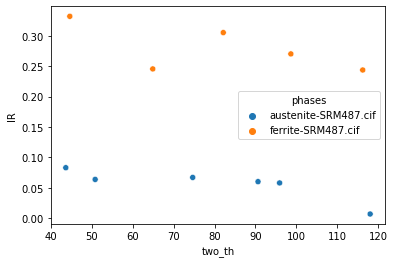

In [8]:
sns.scatterplot(data=mydf,x='two_th',y='IR',hue='phases')

In [21]:
# conjugate priors
def gen_mu_sigma(x,n_draws):
    
    # p(mu,simga) \prop_to 1/sigma OR uniform prior on mu, log(sigma)
    # BDA pg: 66
    
    x_var = np.var(x)
    n_x = x.shape[0]
    v = n_x-1
    tau2 = x_var
    
    sigma2 = invgamma.rvs(a=v/2,scale=v*tau2/2,size=n_draws)
    mu = t.rvs(df=n_x-1, loc=np.mean(x), scale=np.sqrt(x_var/n_x), size=n_draws)
    
    while np.sum(mu < 0) > 0:
        mu[mu < 0] = t.rvs(df=n_x-1, loc=np.mean(x), scale=np.sqrt(x_var/n_x), size=len(mu[mu < 0]))
    
    return mu, sigma2

def get_posterior_samples_cp(I,R,sigma_I,phases,n_draws):

    I = np.array(I)
    R = np.array(R)
    sigma_I = np.array(sigma_I)
    phases = np.array(phases)

    Z = I/R
    unique_phase_names = np.unique(phases)

    res_dict = {}

    for ii in range(len(unique_phase_names)):

        res_dict[unique_phase_names[ii]] = gen_mu_sigma(Z[phases==unique_phase_names[ii]],n_draws)

    return res_dict
    
    

In [37]:
def run_mcmc(I,R,sigma_I,phases,pfs,method,plot=False):

    I = np.array(I)[pfs]
    R = np.array(R)[pfs]
    sigma_I = np.array(sigma_I)[pfs]
    phases = np.array(phases)[pfs]


    phase_counts = np.unique(phases, return_counts=True)[1]

    if np.min(phase_counts) <= 2:
        return None

    phase_names = phases.copy()

    Z = I/R
    unique_phase_names = np.unique(phase_names)

    phases = np.zeros(len(phases),dtype=np.int8)
    
    # create numeric index for each phase
    for ii in range(len(unique_phase_names)):

        phases[phase_names==unique_phase_names[ii]] = int(ii)

    unique_phases = np.unique(phases)
    phase_stds = np.zeros(len(unique_phases))

    # standard deviations for each phase
    for ii in range(len(unique_phases)):

        phase_stds[ii] = np.std(Z[phases==unique_phases[ii]])

    # prior scale and means
    prior_scale=np.mean(phase_stds)
    prior_mean_centers = np.ones(len(unique_phases))

    #print(prior_scale)
    #print(prior_mean_centers)   

    if plot:
        plt.scatter(x=np.arange(len(Z)),y=Z,c=phases)
        print("Z: {}".format(Z))
        print("phases: {}".format(phases))

    basic_model = pm.Model() 

    with basic_model:
        
        # Priors for unknown model parameters
        sigma_exp = pm.HalfStudentT("sigma_exp", sd=prior_scale*2, nu=4,shape=len(unique_phases))
        mu = pm.TruncatedNormal("mu", 
                       mu=prior_mean_centers, 
                       sd=np.std(Z)*10,
                       lower=0,
                       shape=len(unique_phases))
        
        full_sigma = pm.math.sqrt( (1/R**2)*(sigma_I**2) + pm.math.sqr(sigma_exp[phases]) )

        # Likelihood (sampling distribution) of observations
        Y_obs = pm.Normal("Y_obs", mu=mu[phases], sd=full_sigma, observed=Z)

        #if plot:
            #pm.model_to_graphviz(basic_model)

        
        
        if method == 'vi': # this didn't seem to work well at all
            print("Variational Inference")
            mean_field = pm.fit(method="advi")
            
            return mean_field
            
        else:
            trace = pm.sample(1000, return_inferencedata=False,tune=1000)

            mu_norm = np.apply_along_axis(lambda x: x/np.sum(x),1,trace['mu'])

            mu_df = pd.DataFrame(mu_norm,columns=unique_phase_names)
            mu_df = pd.melt(mu_df,value_vars = unique_phase_names,var_name='which_phase',value_name='value')

            #sig_df = pd.DataFrame(trace['sigma_exp'],columns=unique_phase_names)
            #sig_df = pd.melt(sig_df,value_vars = unique_phase_names,var_name='which_phase',value_name='value')

            return {'mu_df':mu_df,'trace':trace,'unique_phase_names':unique_phase_names}

In [78]:
list(mydf['IR'].iloc[0:6])

[0.08315363333560628,
 0.06383545655828585,
 0.06710183760130635,
 0.060237502449908845,
 0.05809065003769631,
 0.007000684082964454]

In [79]:
list(mydf['sig_IR'].iloc[0:6])

[0.0006444425595026399,
 0.0010071384398495427,
 0.0014635006285326794,
 0.0013672190762008974,
 0.003406401354901987,
 0.0035939190704297576]

In [107]:
res1_dsl = combine_effects(mydf['IR'].iloc[0:6],mydf['sig_IR'].iloc[0:6]**2,method_re='iterated')
res2_dsl = combine_effects(mydf['IR'].iloc[6:11],mydf['sig_IR'].iloc[6:11]**2,method_re='iterated')

In [108]:
mn1 = res1_dsl.summary_frame().eff.iloc[7]
mn2 = res2_dsl.summary_frame().eff.iloc[7]
sd1 = res1_dsl.summary_frame().sd_eff.iloc[7]
sd2 = res2_dsl.summary_frame().sd_eff.iloc[7]

In [110]:
samps = np.random.normal(loc=[mn1,mn2],scale=[sd1,sd2],size=(8000,2))
apf_rma = x=samps[:,0]/np.sum(samps,axis=1)

In [119]:
res1_dsl.summary_frame()#.loc['random effect','eff']

,eff,sd_eff,ci_low,ci_upp,w_fe,w_re
0,0.083154,0.000644,0.081891,0.084417,0.528134,0.167814
1,0.063835,0.001007,0.061862,0.065809,0.216239,0.167661
2,0.067102,0.001464,0.064233,0.069970,0.102406,0.167375
3,0.060238,0.001367,0.057558,0.062917,0.117337,0.167444
4,0.058091,0.003406,0.051414,0.064767,0.018903,0.165014
5,0.007001,0.003594,-0.000043,0.014045,0.016981,0.164691
fixed effect,0.072877,0.000468,0.071959,0.073795,1.000000,NaN
random effect,0.056713,0.010519,0.036096,0.077331,NaN,1.000000
fixed effect wls,0.072877,0.005890,0.061333,0.084420,1.000000,NaN
random effect wls,0.056713,0.010519,0.036096,0.077331,NaN,1.000000


In [111]:
np.quantile(apf_rma,[.025,.25,.5,.75,.975])

array([0.10318305, 0.13705136, 0.15451835, 0.170799  , 0.20199725])

<AxesSubplot:ylabel='Count'>

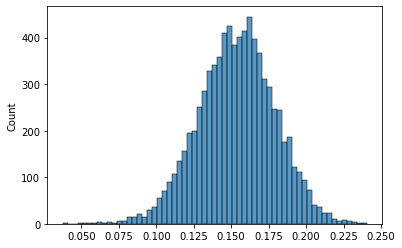

In [112]:
sns.histplot(x=apf_rma)

In [23]:
mydf.phases

0     austenite-SRM487.cif
1       ferrite-SRM487.cif
2     austenite-SRM487.cif
3       ferrite-SRM487.cif
4     austenite-SRM487.cif
5       ferrite-SRM487.cif
6     austenite-SRM487.cif
7     austenite-SRM487.cif
8       ferrite-SRM487.cif
9       ferrite-SRM487.cif
10    austenite-SRM487.cif
Name: phases, dtype: object

Z: [0.08315363 0.33196755 0.06383546 0.24551053 0.06710184 0.30524553
 0.0602375  0.05809065 0.27021445 0.24375222 0.00700068]
phases: [0 1 0 1 0 1 0 0 1 1 0]
Variational Inference


INFO (theano.gof.compilelock): Refreshing lock C:\Users\dtn1\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.7.1-64\lock_dir\lock
INFO (theano.gof.compilelock): Refreshing lock C:\Users\dtn1\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.7.1-64\lock_dir\lock
Average Loss = 0.34638: 100%|██████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1295.76it/s]
Finished [100%]: Average Loss = 0.30175


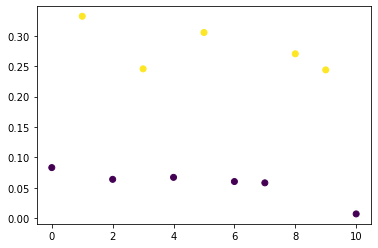

In [38]:
res = run_mcmc(mydf.I,mydf.R,mydf.sigma_I,mydf.phases,np.array([True]*len(mydf.phases)), method='mcmc',plot=True)

In [28]:
apf = res['mu_df'].value[res['mu_df'].which_phase == 'austenite-SRM487.cif']

In [31]:
np.quantile(apf,[.025,.25,.5,.75,.975])

array([0.09332121, 0.14728237, 0.16916028, 0.19056018, 0.23988315])

<AxesSubplot:xlabel='value', ylabel='Count'>

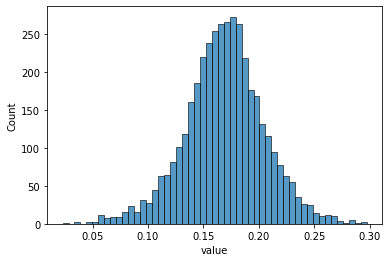

In [29]:
sns.histplot(x=apf)

In [27]:
res['mu_df']

,which_phase,value
0,austenite-SRM487.cif,0.169703
1,austenite-SRM487.cif,0.133843
2,austenite-SRM487.cif,0.188317
3,austenite-SRM487.cif,0.200057
4,austenite-SRM487.cif,0.113091
...,...,...
7995,ferrite-SRM487.cif,0.853269
7996,ferrite-SRM487.cif,0.828290
7997,ferrite-SRM487.cif,0.801562
7998,ferrite-SRM487.cif,0.845942


In [ ]:
dummy = np.unique([1,1,3],return_counts=True)

In [ ]:
dummy[1]

In [ ]:
fig = px.histogram(res['mu_df'],x='value',color='which_phase',opacity=.7,barmode='overlay',histnorm='probability density')

In [ ]:
fig

In [122]:
np.random.normal(1,1,size=4)

array([ 0.67538799, -0.56292907, -0.29313207,  1.00968466])

In [124]:
dummy = pd.DataFrame({
    'x':[1,2,3,4,5,6],
    'g':['a','a','a','b','b','b']
})

In [132]:
px.histogram(dummy,x='x',color='g').add_vline(1)